In [1]:
import numpy as np
from scipy.linalg import hadamard
from scipy.stats import bernoulli
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
N = 8
D = 32
ITERS = 64
X = np.random.randn(N, ITERS, D)

In [3]:
writer = SummaryWriter()

# Stochastic K-Level Quantization

In [4]:
def Bi_k(xi_mins, xi_maxs, k):
    si = xi_maxs - xi_mins
    arr = np.arange(k)*(si/(k-1))
    return xi_mins + arr

def encoder_k(xi, bi, iters, d, k):
    brs = np.zeros((iters, d, 2))
    
    for i in range(iters):
        ids = np.searchsorted(bi[i], xi[i], side='right')-1
        idid = np.vstack((ids, ids+1)).T
        idid[idid==k] = k-1
        brs[i] = bi[i][idid]
        
    probs = np.where(
        ((brs[..., 1] - brs[..., 0]) != 0), 
        np.divide((xi - brs[..., 0]),(brs[..., 1]- brs[..., 0] + (1e-100))), 
        0
    )
    
    return bernoulli.rvs(probs), brs

def decoder_k(enc, brs):
    return np.where(
        enc==1,  brs[..., 1], brs[..., 0]
    )

In [5]:
def sto_k(k, n=N, d=D, ITERS=ITERS, X=X):
    # X = np.random.rand(n, ITERS, d)
        
    Y = np.zeros((ITERS, d))
    
    for xi in X:
        xi_maxs = np.max(xi, axis=1, keepdims=True)
        xi_mins = np.min(xi, axis=1, keepdims=True)
        
        bi = Bi_k(xi_maxs=xi_maxs, xi_mins=xi_mins, k=k)

        encs, brs = encoder_k(xi=xi, bi=bi, k=k,
                            iters=ITERS, d=d)

        yi = decoder_k(encs, brs)
        Y += yi
    x_hat_mean = Y/n 
    x_mean = np.mean(X, axis=0)

    error_obs = np.mean((np.linalg.norm((x_mean - x_hat_mean), axis=1)**2))
    return error_obs

# Stochastic Rotation Quantization

In [6]:
def Bi_rot(zi_mins, zi_maxs, k):
    si = zi_maxs - zi_mins
    arr = np.arange(k)*(si/(k-1))
    return zi_mins + arr

def encoder_rot(zi, bi, iters, d, k):
    brs = np.zeros((iters, d, 2))
    
    for i in range(iters):
        ids = np.searchsorted(bi[i], zi[i], side='right')-1
        idid = np.vstack((ids, ids+1)).T
        idid[idid==k] = k-1
        brs[i] = bi[i][idid]
        
    probs = np.where(
        ((brs[..., 1] - brs[..., 0]) != 0), 
        np.divide((zi - brs[..., 0]),(brs[..., 1]- brs[..., 0] + (1e-100))), 
        0
    )
    
    return bernoulli.rvs(probs), brs

def decoder_rot(enc, brs):
    return np.where(
        enc==1,  brs[..., 1], brs[..., 0]
    )

In [7]:
def sto_rot(k, n=N, d=D, ITERS=ITERS, X=X):
    # X = np.random.rand(n, ITERS, d)
    
    R = hadamard(d) @ np.diag(
        np.random.choice([1, -1], size=d, p=[0.5, 0.5])
    ) / np.sqrt(d)
    
    assert np.allclose(np.eye(d), R @ R.T), "R is not orthogonal."
    
    Y = np.zeros((ITERS, d))
    
    for xi in X:
        zi = np.transpose(R @ xi.T)
        assert np.allclose(
            np.linalg.norm(zi),
            np.linalg.norm(xi)
        ), "l2 norm zi != l2 norm xi"
        
        zi_maxs = np.max(zi, axis=1, keepdims=True)
        zi_mins = np.min(zi, axis=1, keepdims=True)

        bi = Bi_rot(zi_maxs=zi_maxs, zi_mins=zi_mins, k=k)

        encs, brs = encoder_rot(zi=zi, bi=bi, k=k,
                            iters=ITERS, d=d)

        yi = decoder_rot(encs, brs)
        
        Y += yi
    Z_hat_mean = Y/n 
    x_hat_mean = np.transpose(np.linalg.inv(R) @ Z_hat_mean.T)
    x_mean = np.mean(X, axis=0)

    error_obs = np.mean((np.linalg.norm((x_mean - x_hat_mean), axis=1)**2))
    return error_obs

In [8]:
num_k = np.arange(2, 7)
k_mse = np.zeros_like(num_k, dtype=np.float32)
rot_mse = np.zeros_like(num_k, dtype=np.float32)

In [9]:
for i, k in enumerate(tqdm(num_k)):
    k_mse[i] = sto_k(k=k)
    rot_mse[i] = sto_rot(k=k)
    
    # adding to tensorboard
    writer.add_scalars("MSE", {
        "sto_k": k_mse[i],
        "sto_rot": rot_mse[i]
    }, k)


100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.68it/s]


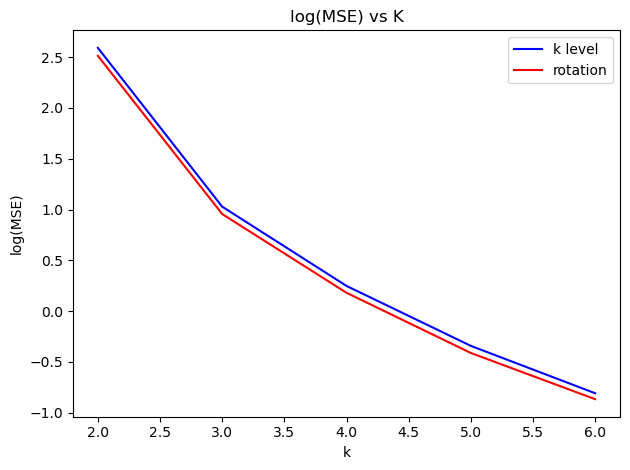

In [15]:
plt.plot(num_k, np.log(k_mse),  'b', label='k level')
plt.plot(num_k, np.log(rot_mse), 'r', label='rotation')
plt.legend()
plt.title("log(MSE) vs K")
plt.xlabel("k")
plt.ylabel('log(MSE)')
plt.tight_layout()
plt.show()